In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as plot_style
import sys
from pathlib import Path
print(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent))
plot_style.use('plots.mplstyle')

/home/francesco/Developing/Integrated_Actin/virtual_lab


In [2]:
from virtual_lab.experiments import *
from virtual_lab.simulation import *
from virtual_lab.model import *
from virtual_lab.utils import *
from examples.required_files.const import *
from examples.required_files.experiment_list import *
from examples.required_files.models import *
from virtual_lab.logger import *
Sim = Simulation()
Sim.save_figs = False
VL_Logger.set_log_level(LogLevel.ERROR)

Set log level to ERROR


In [3]:
variable_labels = {
    "Vpsd": r'$V_{PSD}$',
    "V_tot": r'$V_{tot}$',
    "Vd": r'$V_d$',
    "Vs": r'$V_s$',
    "V_eff": r'$V_{eff}$',
    "Ve": r'$V_m$', 
    "crosslink": 'cross.',
    "stim": "HFS"
}

# Define the EC model

In [4]:
const_base = CONSTANTS.copy()
gamma = const_base["gamma_0"]*const_base["g_mul_LTP"]
mu = const_base["mu_0"]*const_base["m_mul_LTP"]

In [5]:
early_consolidation = BaseModel("EC", {"Vd":None,"Vs":None,"Vpsd":1,"V_eff":None,"V_tot":None},const = const_base,
                                labels = variable_labels)
# early_consolidation.P_ONSET = 15 * 60
# early_consolidation.nf_0 = 0.04
# early_consolidation.nf_LTP = 15.2
# early_consolidation.tau_Vd = 8000
early_consolidation.P_ONSET = 12.5 * 60
early_consolidation.nf_0 = 0.04
early_consolidation.nf_LTD = 0
early_consolidation.nf_LTP = 12
early_consolidation.tau_Vd = 2400
early_consolidation.k_u_0 = 1*20/3/(3600*2)
early_consolidation.k_b_0 = 1*1/3/(600*2)
early_consolidation.k_u_1 = 1000/3/3600
early_consolidation.k_b_1 = 1/3/600
early_consolidation.experiments = create_experiments(early_consolidation)
Sim.add_model(early_consolidation,switching=True)

# Simple ODE integration experiments

## Optimizer code

In [6]:
STC_data = {
    "time_data":[5/60+0.25,1+0.25,2+0.25,4+0.25],
    "volume_data": [1.43,1.32,1.15,0.99],
    "err": [0.15,0.08,0.05,0.08]
}
k_b_k_u_ratio = 1/3

In [7]:
# WEIGHT = np.exp(-np.array(range(10)))
# print(WEIGHT)

In [8]:
from bayes_opt import BayesianOptimization, UtilityFunction

STC_exp = Experiments(
    [Experiment("STC 2 Hours",
                        {"stim": [[300,WTET]],
                        "LFS": [],
                        "crosslink": [[300, X_WTET]],
                        "protein" : [[int(p*60),int(p*60)+3600]] },dt = 1,T = 6*3600) for p in STC_data['time_data']])

def experiment_deviation():
    LTP = early_consolidation.experiments['Basic'].get_experiment("S_TET")
    LTP_results = Sim.run_experiments(LTP)

    exp_data = LTP.experimental_data['Matsuzaki 2004']
    exp_V_LTP = np.array(exp_data['y']) *LTP_results[0]["V_tot"][0]
    exp_t_LTP = np.array(exp_data['x']) *60
    selected_V = LTP_results[0]['V_tot'][exp_t_LTP.astype(int)]

    # For LTP the early phase is the most important
    WEIGHT = np.exp(-np.array(range(len(exp_V_LTP))))
    loss = sum(WEIGHT*((exp_V_LTP-selected_V)/selected_V)**2)

    LTD = early_consolidation.experiments['Basic'].get_experiment("LTD")
    LTD_results = Sim.run_experiments(LTD)

    exp_data = LTD.experimental_data['Kasai Noguchi 2015']
    exp_V_LTD = np.array(exp_data['y']) *LTD_results[0]["V_tot"][0]
    exp_t_LTD = np.array(exp_data['x']) *60
    selected_V = LTD_results[0]['V_tot'][exp_t_LTD.astype(int)]

    # For LTD the late phase is the most important
    WEIGHT = np.exp(-np.array(range(len(exp_V_LTD))))[::-1]*10
    loss += sum(WEIGHT*((exp_V_LTD-selected_V)/selected_V)**2)
    if any(LTD_results[0]['Vpsd']<0.05):
        loss += 1e6

    STC_results = Sim.run_experiments(STC_exp)

    vol_data = STC_data['volume_data']
    time_data = np.asarray(STC_data['time_data'])*60
    selected_Vpsd = []
    for k in range(len(time_data)):
        selected_Vpsd = STC_results[k]['Vpsd'][-1]
    # Here the weight is same for all points
    loss += sum(((vol_data-selected_Vpsd)/selected_Vpsd)**2)
    
    return - loss

def evaluate_params(**params):
    for key,value in params.items():
        setattr(early_consolidation,key,value)
    early_consolidation.experiments = create_experiments(early_consolidation)
    loss = experiment_deviation()
    return loss


In [9]:
# params = optimizer.max['params']
# params['k_b_0'] = k_b_k_u_ratio*params['k_u_0']
# print(params)

### Values from Micha (comment if want own optimized values!)

In [10]:
params_micha = {'nf_0': 0.00025, 'nf_LTD': 0.0, 'nf_LTP': 0.02, 'ratio_0': 3.787769967758817, 'ratio_1': 232.5023763795744, 'ratio_psd': 9.0, 'tau_Vd': 1503.2167264252723, 'tau_u_0': 3379.042736072486, 'tau_u_1': 30.0}

In [11]:
params = params_micha.copy()
params['k_u_0'] = 1/params.pop('tau_u_0')
params['k_u_1'] = 1/params.pop('tau_u_1')

params['k_b_0'] = params['k_u_0'] / 3.8
params['k_b_1'] = params['k_u_1'] / (params.pop('ratio_1'))
params['tau_Vd'] = 4500
params['tau_PSD_mol'] = params['tau_Vd'] / 6.5
params['nu'] = 1
params['nf_LTP'] = 0.04

params.pop('ratio_psd')
print(params)


{'nf_0': 0.00025, 'nf_LTD': 0.0, 'nf_LTP': 0.04, 'ratio_0': 3.787769967758817, 'tau_Vd': 4500, 'k_u_0': 0.0002959418030806901, 'k_u_1': 0.03333333333333333, 'k_b_0': 7.78794218633395e-05, 'k_b_1': 0.00014336771026767753, 'tau_PSD_mol': 692.3076923076923, 'nu': 1}


In [12]:
ranges = {}
relative_change = 0.1
for key,value in params.items():
    ranges[key] = (value-value*relative_change, value+value*relative_change)

In [13]:

# optimizer = BayesianOptimization(
#     f = evaluate_params,
#     pbounds=ranges,
#     random_state=1)

# acquisition_function = UtilityFunction(kind="ucb", kappa=0.1)

# optimizer.maximize(init_points = 50, n_iter = 10, acquisition_function=acquisition_function)

|   iter    |  target   |   k_b_0   |   k_b_1   |   k_u_0   |   k_u_1   |   nf_0    |  nf_LTD   |  nf_LTP   |    nu     |  ratio_0  | tau_PS... |  tau_Vd   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -1.642    | 7.659e-05 | 0.0001497 | 0.0002664 | 0.03202   | 0.0002323 | 0.0       | 0.03749   | 0.9691    | 3.71      | 697.7     | 4.427e+03 |
| 2         | -1.811    | 8.076e-05 | 0.0001349 | 0.0003183 | 0.03018   | 0.0002585 | 0.0       | 0.04047   | 0.9281    | 3.559     | 733.9     | 4.921e+03 |
| 3         | -1.916    | 7.497e-05 | 0.0001489 | 0.0003182 | 0.03596   | 0.0002293 | 0.0       | 0.03736   | 1.076     | 3.483     | 681.4     | 4.912e+03 |
| 4         | -1.969    | 7.84e-05  | 0.0001489 | 0.000285  | 0.03458   | 0.0002667 | 0.0       | 0.042     | 1.098     | 3.976     | 661.9     | 4.76e+03  |
| 5         | -1.8      | 7.17e-05  | 0.0001419 | 0.

KeyboardInterrupt: 

## Set parameters

In [ ]:
# params = optimizer.max['params']
# print(params)

{'k_b_0': 7.198151131300321e-05, 'k_b_1': 0.000130308399403927, 'k_u_0': 0.0002727100240502702, 'k_u_1': 0.031504728924052365, 'nf_0': 0.00026064944901913384, 'nf_LTD': 0.0, 'nf_LTP': 0.036100447841272934, 'nu': 0.9143948559378974, 'ratio_0': 4.1417570176427345, 'tau_PSD_mol': 701.7369870350689, 'tau_Vd': 4232.963911194892}


In [ ]:
# print(params['nf_LTP'])
# params['nf_LTP'] = 12
for key,value in params.items():
    setattr(early_consolidation,key,value)
print(Sim.model.variables.Vpsd)

1


In [ ]:
exp_names = ["STC_LTP_WBS", "S_TET", "LTD","STC_LTD_WBS","LTP_X2","STC_TRLTD"]

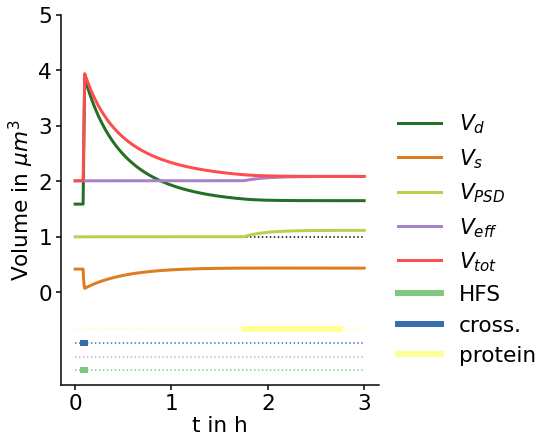

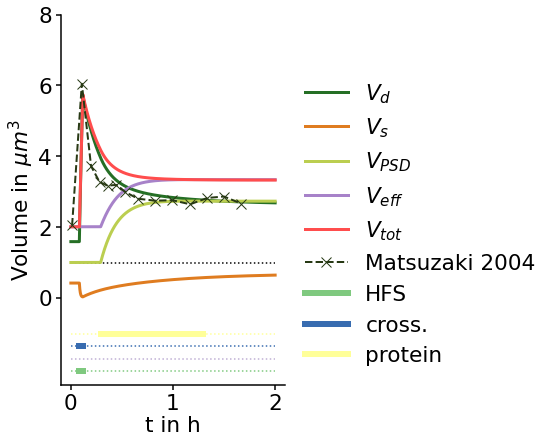

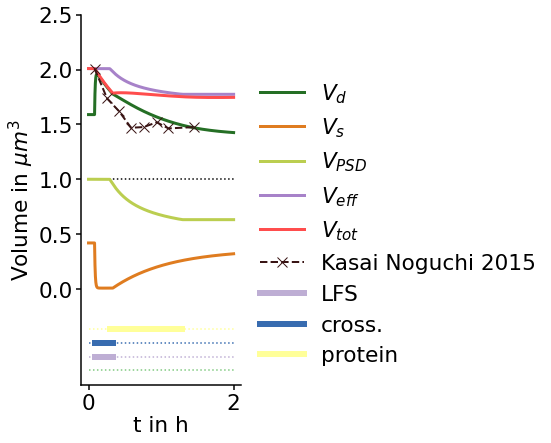

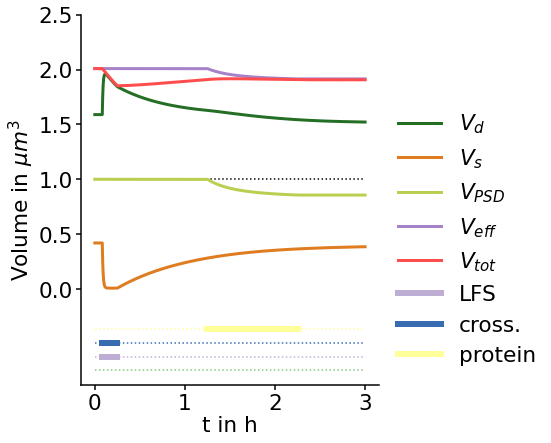

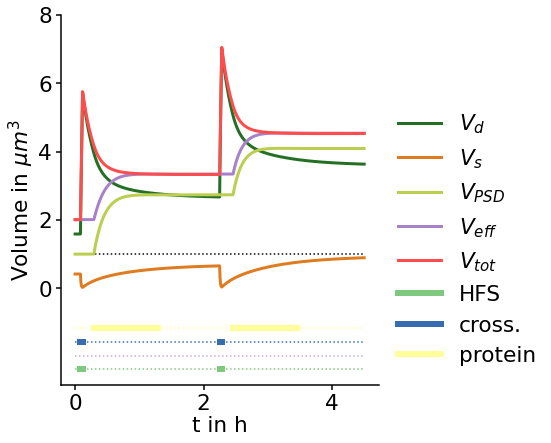

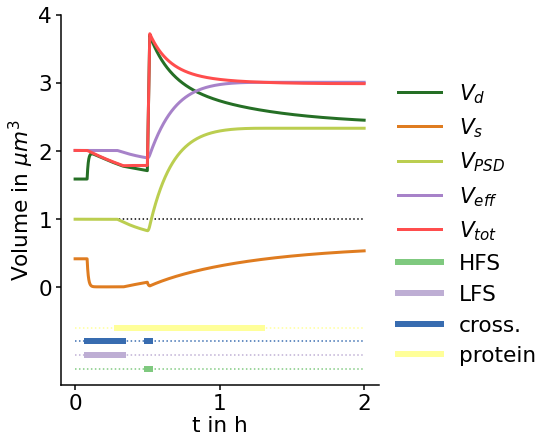

In [ ]:
Sim.switch_model("EC")
experiments = []
for exp_name in exp_names:
    exp = early_consolidation.experiments["Basic"].get_experiment(exp_name)
    _ = Sim.run_experiments(exp, stochastic=False)  
    Sim.plot_results(filename = f"{exp_name}_EC.pdf", time_unit = 'h',
    fontsize = 18,use_title = False, legend = True)                                                

# Protein availability experiments

## LTP

In [ ]:
import numpy as np
short = True
LTP_results = {}
protein_duration = {
    "short": 3600,
    "long": 3*3600
}
protein_times = {
    label: [[max(k-p_d,0),min(k,p_d)] for k in np.arange(100,6*3600+p_d,300)] for label,p_d in protein_duration.items()
}
x_data = {
    label: (np.arange(100,6*3600+protein_duration[label],300) - protein_duration[label] - 300)/3600 for label in protein_duration
}

In [ ]:
for label in ["short","long"]:
    p_d = protein_duration[label]
    ProteinTimeLTP = Experiments(
        [
            Experiment("Protein availability LTP",
                        {"stim": [[300,WTET]],
                        "LFS": [],
                        "crosslink": [[300, X_WTET]],
                        "protein" : [p] },dt = 5,T = 8*3600) for p in protein_times[label]
        ]
    )
    LTP_results[label] = Sim.run_experiments(ProteinTimeLTP)

In [ ]:
# Sim.plot_results([LTP_results['short'][0]],time_interval=[0,100])

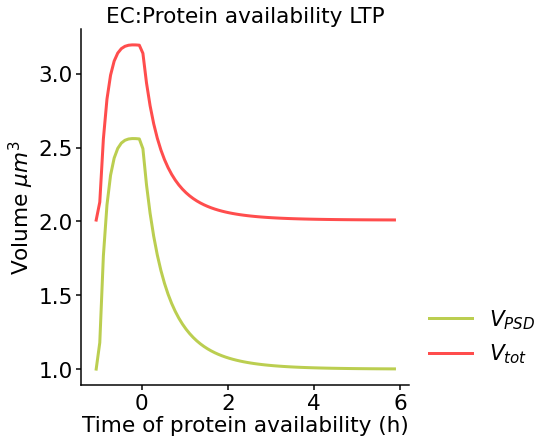

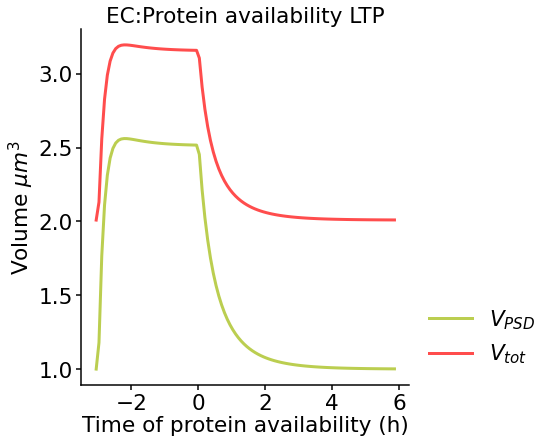

In [ ]:
LTP_data = {}
for label in ['short','long']:
    LTP_data[label] = Sim.plot_selected_points(LTP_results[label],["Vpsd","V_tot"],"last",["stim"], x_data= x_data[label],xlabel = "Time of protein availability (h)",
    ylabel = r"Volume $\mu m^3$", filename = f"LTP_{label}_protein_times_EC.pdf", separate_legend = False, fontsize = 18, return_data = True)

<ErrorbarContainer object of 3 artists>

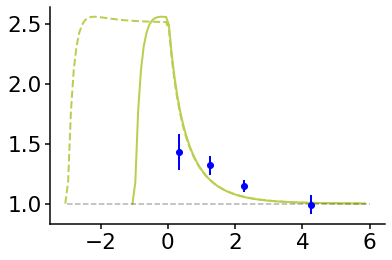

In [ ]:
for label in ['short','long']:
    style = '-' if label == 'short' else '--'
    time = '1h' if label == 'short' else '3h'
    plt.plot(x_data[label], LTP_data[label]['Vpsd'], linestyle = style, linewidth = 2, color = Sim.color_coding['Vpsd'], label = f"LTP, {time}")
plt.plot([-3,6],[1,1],color = 'k',alpha = 0.3,linestyle = '--')
plt.errorbar(STC_data['time_data'],STC_data['volume_data'],yerr=STC_data['err'], linestyle = '', linewidth = 2, marker = '.',markersize = 12, color = 'b',
             label = 'Frey \& Morris, 1998')

## LTD

In [ ]:
LTD_results = {}
LTD_data = {}

In [ ]:
for label in ['short','long']:
    WLFS = Sim.model.WLFS
    ProteinTimeLTD = Experiments(
        [
            Experiment("Protein availability LTD",
                        {"stim": [],
                        "LFS": [[300,WLFS]],
                        "crosslink": [[300, X_WTET]],
                        "protein" : [p] },dt = 5,T = 8*3600) for p in protein_times[label]
        ]
    )
    LTD_results[label] = Sim.run_experiments(ProteinTimeLTD)

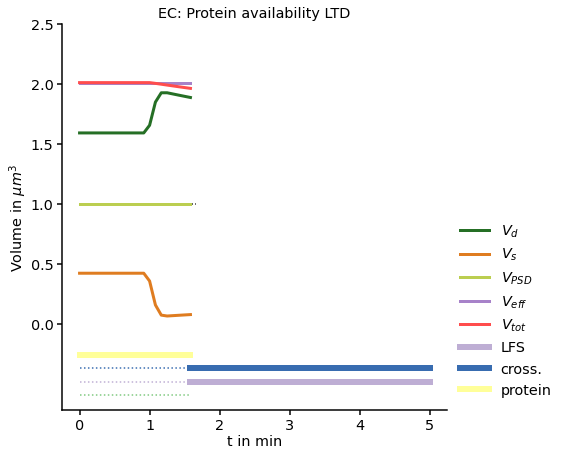

In [ ]:
Sim.plot_results([LTD_results['short'][0]],time_interval=[0,100])

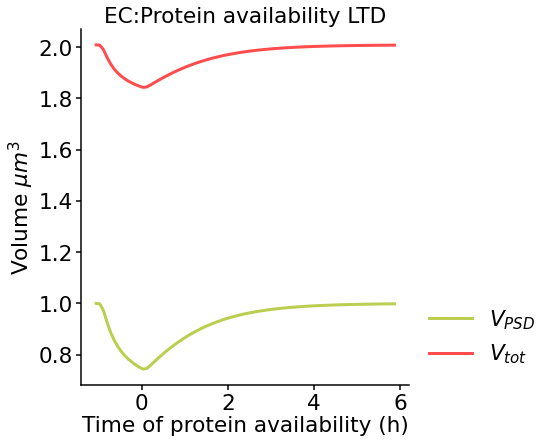

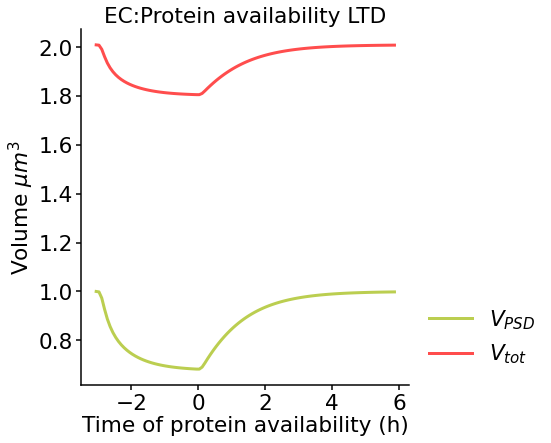

In [ ]:
for label in ['short','long']:
    LTD_data[label] = Sim.plot_selected_points(LTD_results[label],["Vpsd","V_tot"],"last",["stim"], x_data= x_data[label],xlabel = "Time of protein availability (h)",
    ylabel = r"Volume $\mu m^3$", filename = f"LTD_{label}_protein_times_EC.pdf", separate_legend = False, fontsize = 18, return_data = True)

# Composite plot

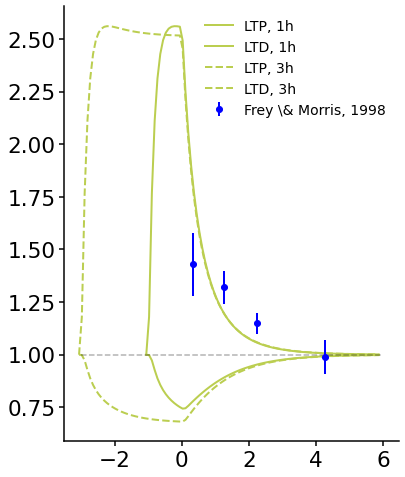

In [ ]:
plt.figure(figsize=(6,8))
for label in ['short','long']:
    style = '-' if label == 'short' else '--'
    time = '1h' if label == 'short' else '3h'
    plt.plot(x_data[label], LTP_data[label]['Vpsd'], linestyle = style, linewidth = 2, color = Sim.color_coding['Vpsd'], label = f"LTP, {time}")
    plt.plot(x_data[label],LTD_data[label]['Vpsd'], linestyle = style,  linewidth = 2, color = Sim.color_coding['Vpsd'], label = f"LTD, {time}")
plt.plot([-3,6],[1,1],color = 'k',alpha = 0.3,linestyle = '--')
plt.errorbar(STC_data['time_data'],STC_data['volume_data'],yerr=STC_data['err'], linestyle = '', linewidth = 2, marker = '.',markersize = 12, color = 'b',
             label = 'Frey \& Morris, 1998')
# plt.ylim((0.5,2.1))
legend = plt.legend(loc = 'upper right',fontsize = 14)
plt.savefig("plots/protein_availability.pdf")

## LTP Spacing experiments

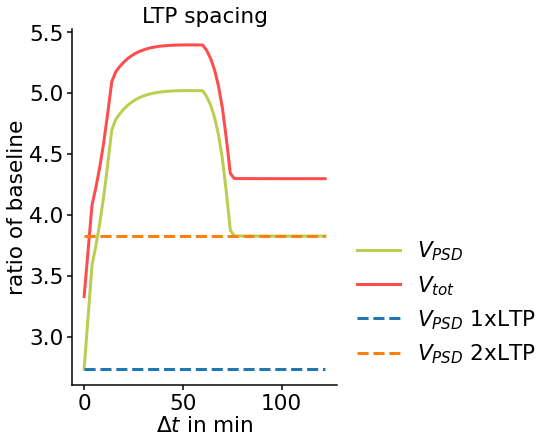

In [ ]:
protein_duration = 1*3600
inter_step = int(protein_duration/3600*2)*60
last_stim = protein_duration+3600
label = 'short' if protein_duration < 3601 else 'long'
P_ONSET = 15*60
LTP_SPACING = Experiments([Experiment(f"LTPx2_{int(t/60)}",
            {"stim": [[300,STET],[300+STET + t,STET]],
            "LFS": [],
            "crosslink": [[300,X_STET],[300+STET + t,X_STET]],
            "protein": [[300+P_ONSET, protein_duration],[300 + t + STET + P_ONSET,protein_duration]]},
            T = 7*3600,dt = 5) for t in np.arange(120,last_stim+inter_step,inter_step)])
LTP_SPACING.add(Sim.model.experiments['Basic'].get_experiment("S_TET"),idx = 0)

LTP_X2 = Experiment("LTP_X2",
                        {"stim": [[300, STET],[last_stim, STET]], 
                        "LFS": [], 
                        "crosslink": [[300, X_STET],[last_stim, X_STET]], 
                        "protein" : [[300+P_ONSET, protein_duration],[last_stim+P_ONSET, protein_duration]] }, T = 7*3600, dt = 5)

spacing = Sim.run_experiments(LTP_SPACING)
ltp2 = Sim.run_experiments(LTP_X2)
x_data = [exp.stim[1][1]-300-STET for exp in LTP_SPACING.experiments[1:]]
x_data.insert(0,0)
x_data = np.array(x_data)/60

reference_values = [spacing[0]["Vpsd"][-1],ltp2[0]["Vpsd"][-1]]
reference_labels = [r"$V_{PSD}$ 1xLTP", r"$V_{PSD}$ 2xLTP"]
Sim.plot_selected_points(spacing,["Vpsd","V_tot"],"last",x_data=x_data, fontsize = 18,
                        reference_values = reference_values, ref_labels = reference_labels, filename=f"LTP-spacing-{label}-protein.pdf",
                        xlabel = r'$\Delta t$ in min', use_legend = True, separate_legend = False, title = "LTP spacing")

In [ ]:
print(spacing[-1]['Vpsd'][-1],ltp2[-1]['Vpsd'][-1])

3.8250859019134267 3.8249967289795443


ValueError: x and y must have same first dimension, but have shapes (5040,) and (1008,)

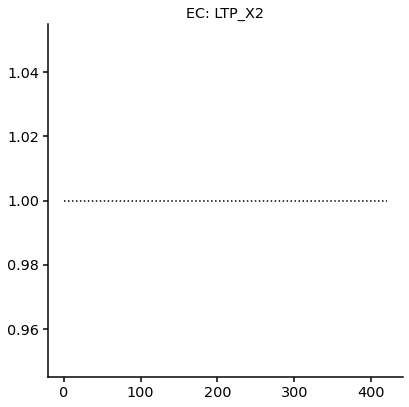

In [ ]:
Sim.plot_comparison(results = [ltp2[0],spacing[-1]], n_cols = 2)

In [ ]:
# Sim.plot_results(spacing, filename="all_spacing_exp.pdf")